## Using machine vision to follow a line. 

In this notebook we'll explore how use machine vision to steer a vehicle so that follows a white line on the floor. To do this we'll use a canny transform to find the edges of the path and hough transforms to measure the angle of the path.


First we'll need packages to download the file, display the images, and analyze the image.

In [172]:
%matplotlib inline 

import os
import tarfile
from urllib.request import urlretrieve 
import numpy as np
from PIL import Image

from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

Download images of an RC vehicle seeing a whie line. 

In [173]:
#download file
path, headers = urlretrieve('https://github.com/wroscoe/donkey/raw/master/datasets/whiteline2.tar.gz', )

(659, 120, 160, 3)


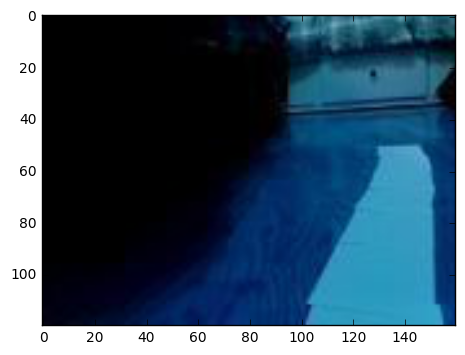

In [174]:
#Extract images into a numpy array.
img_arrays = []
tar = tarfile.open(path, "r:gz")
for m in tar.getmembers():
    f = tar.extractfile(m)
    if f is not None:
        img = Image.open(f)
        img_arrays.append(np.array(img))
        
images = np.array(img_arrays)
print(images.shape)
img = images[550]
imshow(img)

This is one of the 600 images. Now on to the analysis. 

For edge finding we only need a greyscale image. For this example we'll use all RGB channels but it may be advantagous to just use certain channels to find the line.

In [104]:
import skimage
from skimage import feature

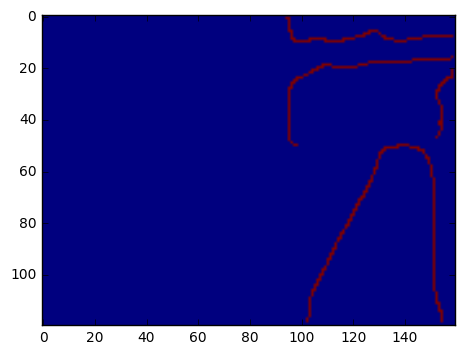

In [111]:
img = skimage.color.rgb2grey(img)
img_can = imshow(feature.canny(img, sigma=3))
img_can = img_can.get_array()

In [112]:
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from matplotlib import cm

160


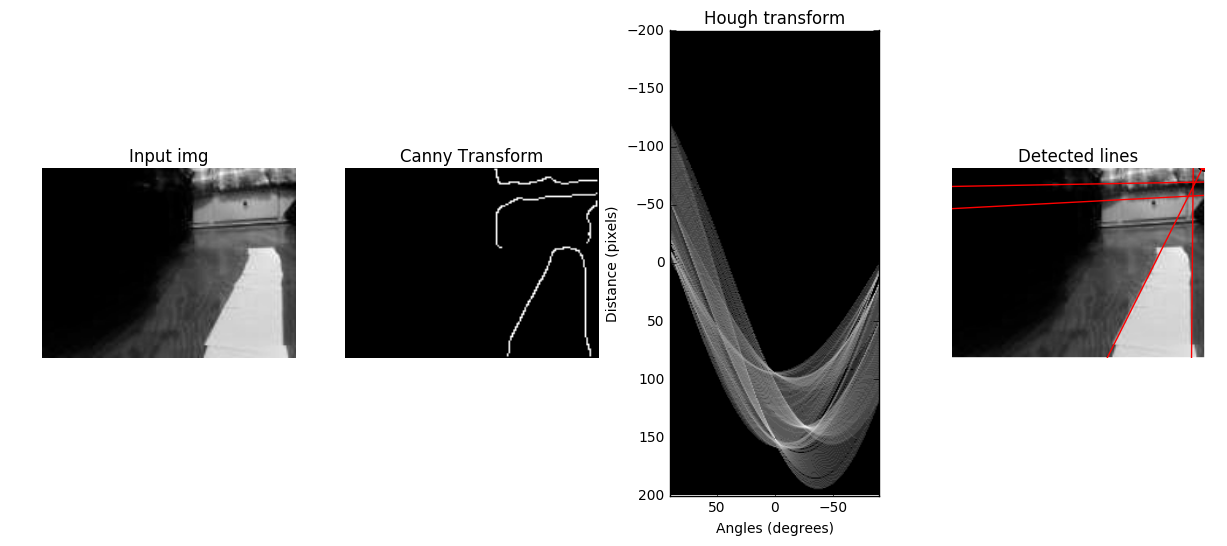

In [171]:
# Classic straight-line Hough transform
h, theta, d = hough_line(img_can)

fig, axes = plt.subplots(1, 4, figsize=(15, 6),
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(img, cmap=cm.gray)
ax[0].set_title('Input img')
ax[0].set_axis_off()


ax[1].imshow(img_can, cmap=cm.gray)
ax[1].set_title('Canny Transform')
ax[1].set_axis_off()

ax[2].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap=cm.gray, aspect=1/1.5)
ax[2].set_title('Hough transform')
ax[2].set_xlabel('Angles (degrees)')
ax[2].set_ylabel('Distance (pixels)')
ax[2].axis('image')

ax[3].imshow(img, cmap=cm.gray)
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - img.shape[1] * np.cos(angle)) / np.sin(angle)
    ax[3].plot((0, img.shape[1]), (y0, y1), '-r')
ax[3].set_xlim((0, img.shape[1]))
ax[3].set_ylim((img.shape[0], 0))
ax[3].set_axis_off()
ax[3].set_title('Detected lines')

dist= 141.854636591
angle=0.465096119107
ax[3].scatter([0, img.shape[1]], 
                [(dist - 0 * np.cos(angle)) / np.sin(angle), (dist - img.shape[1] * np.cos(angle)) / np.sin(angle)],
               c='r', s=90)

print(img.shape[1])


In [149]:
import math
for x, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    print(x, angle, dist)

54 0.465096119107 141.854636591
51 0.00877539847371 152.882205514
39 1.51814393595 25.5639097744
32 1.55324552985 11.5288220551


## Find the angle of the path at y = 0

Slice the image to only show the bottom third.


### Find the offset of the path from the middle of the picture.

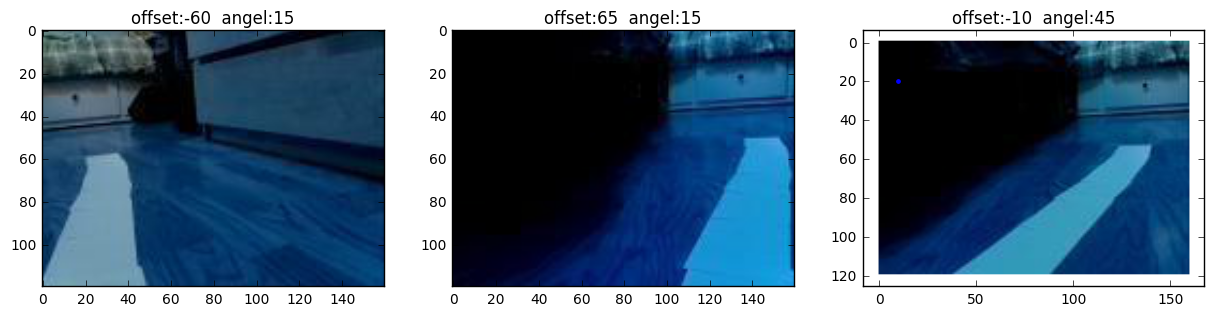

In [142]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6),
                         subplot_kw={'adjustable': 'box-forced'})
axes[0].imshow(images[20])
axes[0].set_title('offset:-60  angel:15')

axes[1].imshow(images[240])
axes[1].set_title('offset:65  angel:15')

axes[2].imshow(images[300])
axes[2].set_title('offset:-10  angel:45')

plt.scatter([10], [20])

Logic: The vehicle should turn toward the offset. If the offset is zer, the vehicle should turn the angle of the path. 